Sebastian Raschka, 2015

# Python Machine Learning Essentials

# Chapter 6 - Learning Best Practices for Model Evaluation and Hyperparameter Tuning

Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -u -d -v -p numpy,pandas,matplotlib,scikit-learn

Sebastian Raschka 
Last updated: 08/20/2015 

CPython 3.4.3
IPython 3.2.1

numpy 1.9.2
pandas 0.16.2
matplotlib 1.4.3
scikit-learn 0.16.1


In [ ]:
# to install watermark just uncomment the following line:
#%install_ext https://raw.githubusercontent.com/rasbt/watermark/master/watermark.py

<br>
<br>

### Sections



- [Streamlining workflows with pipelines](#Streamlining-workflows-with-pipelines)
    - [Loading the Breast Cancer Wisconsin dataset](#Loading-the-Breast-Cancer-Wisconsin-dataset)
    - [Combining transformers and estimators in a pipeline](#Combining-transformers-and-estimators-in-a-pipeline)
- [Using k-fold cross validation to assess model performances](#Using-k-fold-cross-validation-to-assess-model-performances)
- [Debugging algorithms with learning curves](#Debugging-algorithms-with-learning-curves)
    - [Diagnosing bias and variance problems with learning curves](#Diagnosing-bias-and-variance-problems-with-learning-curves)
    - [Addressing over- and underfitting with validation curves](#Addressing-over--and-underfitting-with-validation-curves)
- [Fine-tuning machine learning models via grid search](#Fine-tuning-machine-learning-models-via-grid-search)
    - [Tuning hyperparameters via grid search ](#Tuning-hyperparameters-via-grid-search)
    - [Algorithm selection with nested cross-validation](#Algorithm-selection-with-nested-cross-validation)
- [Looking at different performance evaluation metrics](#Looking-at-different-performance-evaluation-metrics)
    - [Reading a confusion matrix](#Reading-a-confusion-matrix)
    - [Optimizing the precision and recall of a classification model](#Optimizing-the-precision-and-recall-of-a-classification-model)
    - [Plotting a receiver operating characteristic](#Plotting-a-receiver-operating-characteristic)
    - [Scoring metrics for multiclass classification](#Scoring-metrics-for-multiclass-classification)

<br>
<br>

[[back to top](#Sections)]

# Streamlining workflows with pipelines

[[back to top](#Sections)]

## Loading the Breast Cancer Wisconsin dataset

In [12]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [13]:
df.shape

(569, 32)

In [14]:
from sklearn.preprocessing import LabelEncoder
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.transform(['M', 'B'])

array([1, 0])

In [15]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=0.20, random_state=1)

<br>
<br>

## Combining transformers and estimators in a pipeline

[[back to top](#Sections)]

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe_lr = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=2)),
            ('clf', LogisticRegression(random_state=1))])

pipe_lr.fit(X_train, y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))
y_pred = pipe_lr.predict(X_test)

Test Accuracy: 0.947


<br>
<br>

# Using k-fold cross validation to assess model performances

[[back to top](#Sections)]

In [17]:
import numpy as np
from sklearn.cross_validation import StratifiedKFold

kfold = StratifiedKFold(y=y_train, 
                        n_folds=10,
                        random_state=1)

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1, np.bincount(y_train[train]), score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold: 1, Class dist.: [256 153], Acc: 0.891
Fold: 2, Class dist.: [256 153], Acc: 0.978
Fold: 3, Class dist.: [256 153], Acc: 0.978
Fold: 4, Class dist.: [256 153], Acc: 0.913
Fold: 5, Class dist.: [256 153], Acc: 0.935
Fold: 6, Class dist.: [257 153], Acc: 0.978
Fold: 7, Class dist.: [257 153], Acc: 0.933
Fold: 8, Class dist.: [257 153], Acc: 0.956
Fold: 9, Class dist.: [257 153], Acc: 0.978
Fold: 10, Class dist.: [257 153], Acc: 0.956

CV accuracy: 0.950 +/- 0.029


In [18]:
from sklearn.cross_validation import cross_val_score

scores = cross_val_score(estimator=pipe_lr, 
                         X=X_train, 
                         y=y_train, 
                         cv=10,
                         n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [ 0.89130435  0.97826087  0.97826087  0.91304348  0.93478261  0.97777778
  0.93333333  0.95555556  0.97777778  0.95555556]
CV accuracy: 0.950 +/- 0.029


<br>
<br>

# Debugging algorithms with learning curves

[[back to top](#Sections)]

<br>
<br>

## Diagnosing bias and variance problems with learning curves

[[back to top](#Sections)]

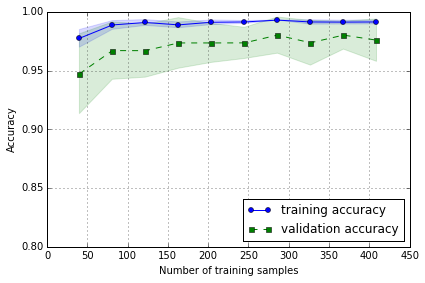

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve

pipe_lr = Pipeline([('scl', StandardScaler()),
            ('clf', LogisticRegression(penalty='l2', random_state=0))])

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                train_sizes=np.linspace(0.1, 1.0, 10), 
                cv=10,
                n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes, 
                 train_mean + train_std,
                 train_mean - train_std, 
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(train_sizes, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('./figures/learning_curve.png', dpi=300)
plt.show()

<br>
<br>

## Addressing over- and underfitting with validation curves

[[back to top](#Sections)]

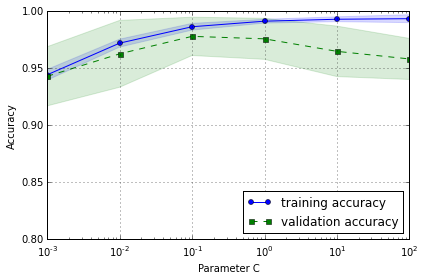

In [20]:
from sklearn.learning_curve import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                param_name='clf__C', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('./figures/validation_curve.png', dpi=300)
plt.show()

<br>
<br>

# Fine-tuning machine learning models via grid search

[[back to top](#Sections)]

<br>
<br>

## Tuning hyperparameters via grid search 

[[back to top](#Sections)]

In [21]:
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC

pipe_svc = Pipeline([('scl', StandardScaler()),
            ('clf', SVC(random_state=1))])

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'clf__C': param_range, 
               'clf__kernel': ['linear']},
                 {'clf__C': param_range, 
                  'clf__gamma': param_range, 
                  'clf__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.978021978022
{'clf__kernel': 'linear', 'clf__C': 0.1}


In [22]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.965


<br>
<br>

## Algorithm selection with nested cross-validation

[[back to top](#Sections)]

In [23]:
gs = GridSearchCV(estimator=pipe_svc, 
                            param_grid=param_grid, 
                            scoring='accuracy', 
                            cv=5)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.978 +/- 0.012


In [24]:
from sklearn.tree import DecisionTreeClassifier
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0), 
                            param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}], 
                            scoring='accuracy', 
                            cv=5)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.908 +/- 0.045


<br>
<br>

# Looking at different performance evaluation metrics

[[back to top](#Sections)]

<br>
<br>

## Reading a confusion matrix

[[back to top](#Sections)]

In [25]:
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


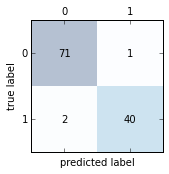

In [26]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()
# plt.savefig('./figures/confusion_matrix.png', dpi=300)
plt.show()

<br>
<br>

## Optimizing the precision and recall of a classification model

[[back to top](#Sections)]

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.976
Recall: 0.952
F1: 0.964


In [28]:
from sklearn.metrics import make_scorer, f1_score

scorer = make_scorer(f1_score, pos_label=0)

c_gamma_range = [0.01, 0.1, 1.0, 10.0]

param_grid = [{'clf__C': c_gamma_range, 
               'clf__kernel': ['linear']},
                 {'clf__C': c_gamma_range, 
                  'clf__gamma': c_gamma_range, 
                  'clf__kernel': ['rbf'],}]

gs = GridSearchCV(estimator=pipe_svc, 
                                param_grid=param_grid, 
                                scoring=scorer, 
                                cv=10,
                                n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.982798668208
{'clf__kernel': 'linear', 'clf__C': 0.1}


<br>
<br>

## Plotting a receiver operating characteristic

[[back to top](#Sections)]

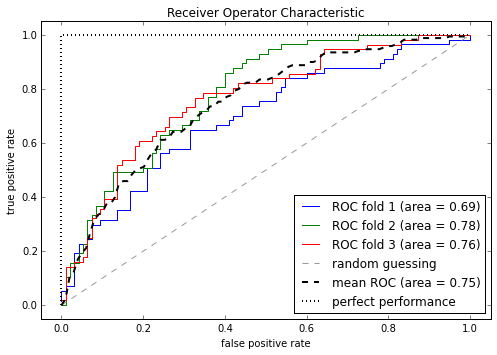

In [80]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

X_train2 = X_train[:, [4, 14]]

cv = StratifiedKFold(y_train, n_folds=3, random_state=1)

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train], 
                         y_train[train]).predict_proba(X_train2[test])
    
    fpr, tpr, thresholds = roc_curve(y_train[test], 
                                     probas[:, 1], 
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, 
             tpr, 
             lw=1, 
             label='ROC fold %d (area = %0.2f)' 
                    % (i+1, roc_auc))

plt.plot([0, 1], 
         [0, 1], 
         linestyle='--', 
         color=(0.6, 0.6, 0.6), 
         label='random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1], 
         [0, 1, 1], 
         lw=2, 
         linestyle=':', 
         color='black', 
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc="lower right")

plt.tight_layout()
# plt.savefig('./figures/roc.png', dpi=300)
plt.show()

In [79]:
pipe_svc = pipe_svc.fit(X_train2, y_train)
y_pred2 = pipe_svc.predict(X_test[:, [4, 14]])

In [71]:
from sklearn.metrics import roc_auc_score, accuracy_score
print('ROC AUC: %.3f' % roc_auc_score(y_true=y_test, y_score=y_pred2))
print('Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred2))

ROC AUC: 0.671
Accuracy: 0.728


<br>
<br>

## Scoring metrics for multiclass classification

[[back to top](#Sections)]

In [31]:
pre_scorer = make_scorer(score_func=precision_score, 
                         pos_label=1, 
                         greater_is_better=True, 
                         average='micro')

<br>
<br>

<br>
<br>